In [1]:
!nvidia-smi

Thu Dec 10 23:33:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 450.57       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:18:00.0 Off |                  N/A |
| 43%   71C    P8     4W / 250W |    835MiB / 11016MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# import shutil  
# shutil.rmtree('Lab13-2 dataset')  

In [3]:
# import zipfile as zf
# files = zf.ZipFile("words_captcha.zip", 'r')
# files.extractall('Lab13-2 dataset')
# files.close()

In [4]:
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8000)])
    except RuntimeError as e:
        print(e)

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [6]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

# 一、載入data

In [7]:
id=[]
final_label =[]
path = 'Lab13-2 dataset/words_captcha/spec_train_val.txt'
f = open(path, 'r')
for label in f:
    id.append(label.split()[0])
    new_label = label.split()[1][0]
    for j in range(1,len(label.split()[1])):
        
        temp = label.split()[1][j]
        new_label = new_label+" "+temp
    caption = '<start> ' + new_label + ' <end>'
    final_label.append(caption)
f.close()

In [8]:
image = []
for i in range(140000):
    image.append("Lab13-2 dataset/words_captcha/"+"a"+str(i)+".png")


In [9]:
train_captions = final_label
img_name_vector = image

num_examples = 120000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [10]:
len(train_captions), len(img_name_vector)

(120000, 120000)

In [11]:
def load_image(image_path,cap):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (160, 300))
    img = tf.image.rgb_to_grayscale(img)
    img = img/255*2-1
    #img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, cap

# 二、建立模型

In [12]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [13]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [14]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [15]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [16]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [17]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [18]:
# Create training and validation sets using an 80-20 split
img_name_train =img_name_vector[:100000]
img_name_val = img_name_vector[100000:]                                                                
cap_train = cap_vector[:100000]
cap_val = cap_vector[100000:]                                                                                     

In [19]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(100000, 100000, 20000, 20000)

In [20]:
# Feel free to change these parameters according to your system's configuration
BATCH_SIZE = 100
BUFFER_SIZE = 5000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
num_steps = len(img_name_val) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [21]:
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [22]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
#dataset = dataset.map(load_image)
dataset = dataset.map(
    load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))

# Use map to load the numpy files in parallel
#val_dataset = val_dataset.map(load_image)
val_dataset = val_dataset.map(
    load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# Shuffle and batch
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# BahdanauAttention

In [23]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

## Encoder  內有自己設計的架構

In [24]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim,**kwargs):
        super(CNN_Encoder, self).__init__(**kwargs)
        # shape after fc == (batch_size, 64, embedding_dim)
        self.c1 = tf.keras.layers.Conv2D(32, 3, strides=1,activation="relu")
        self.m1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
        
        self.c2 = tf.keras.layers.Conv2D(64, 3, strides=1,activation="relu")
        self.m2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
        
        self.c3 = tf.keras.layers.Conv2D(128, 3, strides=1,activation="relu")
        self.m3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
        
        self.c4 = tf.keras.layers.Conv2D(256, 3, strides=1,activation="relu")
        self.m4 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
        
        self.c5 = tf.keras.layers.Conv2D(embedding_dim, 3, strides=1,activation="relu")
        self.m5 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
        
    def call(self, x):
        x = self.c1(x)
        x = self.m1(x)
        
        x = self.c2(x)
        x = self.m2(x)
        
        x = self.c3(x)
        x = self.m3(x)
        
        
        x = self.c4(x)
        x = self.m4(x)
        
        x = self.c5(x)
        x = self.m5(x)
        x = tf.reshape(x, (x.shape[0], -1, x.shape[3]))
        
        return x

## Decoder

In [26]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [27]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [28]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [29]:
checkpoint_path = "./checkpoints/train17"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [30]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [31]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

# 三、開始training

In [32]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [33]:
@tf.function
def validation_step(img_tensor, target):
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    features = encoder(img_tensor)
   
    pred_result = tf.zeros((target.shape[0], 1),dtype=tf.float32)

    for i in range(1, target.shape[1]):
        # passing the features through the decoder
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        dec_input = tf.expand_dims(tf.cast(tf.argmax(predictions, axis=1),tf.float32), 1)
       
        pred_result = tf.concat((pred_result,dec_input),axis=1)
   
    Target = target[:,1:]
    Pred = pred_result[:,1:]
   
    mask = tf.math.logical_not(tf.math.equal(Target, 0))
   
    mask = tf.cast(mask, dtype = Pred.dtype)
    Target = tf.cast(Target, dtype = Pred.dtype)
   
    Pred *= mask
   
    is_the_same = tf.reduce_all(tf.math.equal(Pred, Target), axis=1)
    acc = tf.math.reduce_mean(tf.cast(is_the_same, tf.float32))

    return acc

# validation accuracy 超過0.9

In [34]:
EPOCHS = 15

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
    accur = 0
    for (batch, (img_tensor, target)) in enumerate(val_dataset):
         accur += validation_step(img_tensor, target)
#         if batch % 100 == 0:
#             print ('Epoch {} Batch {} Loss {:.4f}'.format(
#               epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
    
    if epoch % 5 == 0:
        ckpt_manager.save()
    
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('accuracy {}'.format(accur/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Loss 8.429667
accuracy 0.014599990099668503
Time taken for 1 epoch 95.50644779205322 sec

Epoch 2 Loss 3.223623
accuracy 0.48820003867149353
Time taken for 1 epoch 86.61629700660706 sec

Epoch 3 Loss 1.083975
accuracy 0.7585500478744507
Time taken for 1 epoch 85.8757905960083 sec

Epoch 4 Loss 0.568286
accuracy 0.8351500034332275
Time taken for 1 epoch 85.24988770484924 sec

Epoch 5 Loss 0.359620
accuracy 0.8689499497413635
Time taken for 1 epoch 85.27937841415405 sec

Epoch 6 Loss 0.272444
accuracy 0.8735998272895813
Time taken for 1 epoch 85.13059377670288 sec

Epoch 7 Loss 0.267327
accuracy 0.8988998532295227
Time taken for 1 epoch 84.03714919090271 sec

Epoch 8 Loss 0.184461
accuracy 0.9105001091957092
Time taken for 1 epoch 85.02520203590393 sec



KeyboardInterrupt: 

## loss plot

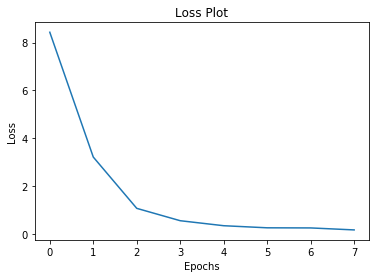

In [35]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [36]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [37]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

# test data 輸出

In [41]:
test_name_vector = []
cap_test = []
for i in range(120000,140000):
    test_name_vector.append("Lab13-2 dataset/words_captcha/"+'a'+str(i)+'.png')
    cap_test.append('<start>')

dataset_test = tf.data.Dataset.from_tensor_slices((test_name_vector, cap_test))
dataset_test = dataset_test.map(load_image).batch(BATCH_SIZE)

output_file = open('./test_prediction.txt', 'w')
for (batch_test, (img_tensor_test, target_test)) in enumerate(dataset_test):
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    features = encoder(img_tensor_test)

    pred_result = tf.zeros((target_test.shape[0], 1),dtype=tf.float32)
    for i in range(1, 7):
        # passing the features through the decoder
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        dec_input = tf.expand_dims(tf.cast(tf.argmax(predictions, axis=1),tf.float32), 1)

        pred_result = tf.concat((pred_result,dec_input),axis=1)
    pred = pred_result[:,1:]
    mask = tf.math.logical_not(tf.math.equal(pred, 0))

    for i in range(BATCH_SIZE):
        output = 'a'+str(batch_test*BATCH_SIZE+i+120000)+'.png'
        pred_index = tf.cast(pred[i],dtype = tf.int32).numpy()
        pred_index_clear = []
        for j in (pred_index):
            if(j == 2):
                break
            pred_index_clear.append(j)
        pred_str = [tokenizer.index_word[j] for j in pred_index_clear]
        output =output+' '+(''.join(pred_str))
        output_file.write(output+'\n')
output_file.close()


